In [1]:
# Install spconv 1.2 steps
# conda create --name spconv12 python=3.8.6 pytorch=1.7.0 cudatoolkit=10.1.243 cudatoolkit-dev=10.1.243 cmake=3.19.1 --channel pytorch --channel=conda-forge
# conda activate spconv12
# conda install cudnn=7.6.5
# cd spconv12
# CUDA_ROOT=/home/starlet/anaconda3/envs/spconv12 python setup.py bdist_wheel
# cd dist/
# pip install spconv-1.2.1-cp38-cp38-linux_x86_64.whl

In [ ]:
# DO NOT WORK
# Install spconv 1.2 steps
# conda create --name spconv12cuda11 python=3.8.6 pytorch=1.7.1 cudatoolkit=11.0.221 cudatoolkit-dev=10.1.243 cmake=3.18.2 --channel pytorch --channel=conda-forge
# conda activate spconv12cuda11
# cd spconv12
# CUDA_ROOT=/home/starlet/anaconda3/envs/spconv12cuda11 python setup.py bdist_wheel
# cd dist/
# pip install spconv-1.2.1-cp38-cp38-linux_x86_64.whl

In [ ]:
# DO NOT WORK
# Install spconv 1.2 steps
# conda create --name spconv12cuda102 python=3.8.6 pytorch=1.7.1 cudatoolkit=10.2.89 cudatoolkit-dev cmake=3.18.2 --channel pytorch --channel=conda-forge
# conda activate spconv12cuda102
# cd spconv12
# CUDA_ROOT=/home/starlet/anaconda3/envs/spconv12cuda102 python setup.py bdist_wheel
# cd dist/
# pip install spconv-1.2.1-cp38-cp38-linux_x86_64.whl

In [ ]:
# conda create --name PCDet python=3.8.4 pytorch=1.5.1 cudatoolkit=10.1.243 cudatoolkit-dev=10.1.243 cmake=3.18.0 --channel pytorch --channel=conda-forge

In [3]:
import sys
sys.path.append('../input/3d-object-detection-for-autonomous-vehicles/solution/second')

In [4]:
ARTIFACTS_FOLDER = './lyft_artifacts'

In [7]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

import os
os.environ['OMP_NUM_THREADS'] = '1'
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [8]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar

In [12]:
level5data = LyftDataset(data_path = '/kaggle/input/3d-object-detection-for-autonomous-vehicles', 
                        json_path = '/kaggle/input/3d-object-detection-for-autonomous-vehicles/train_data',
                        verbose = True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 7.3 seconds.
Reverse indexing ...
Done reverse indexing in 1.8 seconds.


In [13]:
os.makedirs(ARTIFACTS_FOLDER, exlevel5dateist_ok = True)

In [14]:
classes = ['car', 'motorcycle', 'bus', 'bicycle', 'truck', 'pedestrian', 'other_vehicle', 'animal', 'emergency_vehicle']

In [17]:
level5data.scene

[{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
  'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
  'description': '',
  'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
  'nbr_samples': 126,
  'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'},
 {'description': '',
  'first_sample_token': '3b30673b9d944ec6058ef5a8debb4c0a6fe075bca7076e06cf42a2bc10dc446e',
  'log_token': '0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3aec5e76e718771b30e',
  'name': 'host-a006-lidar0-1236037883198113706-1236037908098879296',
  'token': '0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3aec5e76e718771b30e',
  'last_sample_token': '5ec01e4634ca91751311eaafb45a9196ba8616bf05edc85593aff158db653a34',
  'nbr_samples': 126},
 {'first_sample_token': 'fcad797faa988f50be306e5fb6971de295602ee9116bd9ce05cfb514f

In [24]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]
len(records)

180

In [27]:
entries = []
for start_time, record in records:
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000
    date = datetime.utcfromtimestamp(start_time)
    token = record['token']
    name = record['name']
    host = '-'.join(record['name'].split('-')[:2])
    first_sample_token = record['first_sample_token']
    
    entries.append((host, name, date, token, first_sample_token))
    
df = pd.DataFrame(entries, columns = ['host', 'scene_name', 'date', 'scene_token', 'first_sample_token'])

In [29]:
df.head()

,host,scene_name,date,scene_token,first_sample_token
0,host-a101,host-a101-lidar0-1241893239199111666-124189326...,2019-05-14 18:20:39.302415,da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e...,24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa...
1,host-a006,host-a006-lidar0-1236037883198113706-123603790...,2019-03-07 23:51:23.300888,0a6839d6ee6804113bb5591ed99cc70ad883d0cff396e3...,3b30673b9d944ec6058ef5a8debb4c0a6fe075bca7076e...
2,host-a011,host-a011-lidar0-1235950297199142196-123595032...,2019-03-06 23:31:37.302078,a939e6edc494777d058c3b1eafb91a7236f6b4ff5e98c9...,fcad797faa988f50be306e5fb6971de295602ee9116bd9...
3,host-a012,host-a012-lidar0-1235937130198577346-123593715...,2019-03-06 19:52:10.301498,e8f8379c823fd0505b63f2612505e1d3de1018ecc3328f...,8e1f13379721c1ab1d073607534ce7c195143cb8911715...
4,host-a101,host-a101-lidar0-1240875136198305786-124087516...,2019-05-02 23:32:16.302353,ccc0662a4dbc63f589358ac9589b677f6d4165a128af93...,b6380a94d11315d22fd2313ae2e627ccb3579150cc9c67...


In [89]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")

140 40 train/validation split scene counts


## B. Creating input and targets

In [90]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get('sample', sample_token)
sample

{'next': 'c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d',
 'prev': '',
 'token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'timestamp': 1557858039302414.8,
 'scene_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'data': {'CAM_BACK': '542a9e44f2e26221a6aa767c2a9b90a9f692c3aee2edb7145256b61e666633a4',
  'CAM_FRONT_ZOOMED': '9c9bc711d93d728666f5d7499703624249919dd1b290a477fcfa39f41b26259e',
  'LIDAR_FRONT_RIGHT': '8cfae06bc3d5d7f9be081f66157909ff18c9f332cc173d962460239990c7a4ff',
  'CAM_FRONT': 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
  'CAM_FRONT_LEFT': 'f47a5d143bcebb24efc269b1a40ecb09440003df2c381a69e67cd2a726b27a0c',
  'CAM_FRONT_RIGHT': '5dc54375a9e14e8398a538ff97fbbee7543b6f5df082c60fc4477c919ba83a40',
  'CAM_BACK_RIGHT': 'ae8754c733560aa2506166cfaf559aeba670407631badadb065a9ffe7c337a7d',
  'CAM_BACK_LEFT': '01c0eecd4b56668e949143e02a117b5683025766d186920099d1e918c23c8b4b',
  'LIDAR

In [91]:
sample_lidar_token = sample['data']['LIDAR_TOP']
lidar_data = level5data.get('sample_data', sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
lidar_data

{'is_key_frame': True,
 'prev': '',
 'fileformat': 'bin',
 'token': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
 'timestamp': 1557858039302414.8,
 'next': 'b2fb6b275352ff1bc8d63cae2ec88561dddb044cae6f8e6ee7ada4ed07d79dc7',
 'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
 'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'calibrated_sensor_token': '82130f5d48b806b62fec95989081337218fbf338ebcc95115d8afcebb305630c',
 'filename': 'lidar/host-a101_lidar1_1241893239302414726.bin',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [92]:
ego_pose = level5data.get('ego_pose', lidar_data['ego_pose_token'])
calibrated_sensor = level5data.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
calibrated_sensor

{'sensor_token': '25bf751d7e35f295393d8a418731474b21c1f702e878c4553f112397caa48c08',
 'rotation': [0.006336712035703651,
  -0.011344169002788682,
  7.18908018654885e-05,
  0.9999155718069028],
 'camera_intrinsic': [],
 'translation': [1.1970962545449502,
  3.680498291456359e-05,
  1.8279670539933053],
 'token': '82130f5d48b806b62fec95989081337218fbf338ebcc95115d8afcebb305630c'}

In [93]:
global_from_car = transform_matrix(ego_pose['translation'],
                                  Quaternion(ego_pose['rotation']), inverse = False)
car_from_sensor = transform_matrix(calibrated_sensor['translation'],
                                  Quaternion(calibrated_sensor['rotation']), inverse = False)
print(global_from_car, car_from_sensor)

[[-2.79019260e-01  9.60278651e-01 -3.62842040e-03  1.00723328e+03]
 [-9.60285129e-01 -2.79013810e-01  1.94042865e-03  1.72542173e+03]
 [ 8.50972801e-04  4.02573511e-03  9.99991535e-01 -2.45800007e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-9.99662312e-01 -1.26739852e-02 -2.26855114e-02  1.19709625e+00]
 [ 1.26707230e-02 -9.99919682e-01  2.87538929e-04  3.68049829e-05]
 [-2.26873336e-02 -8.12874261e-17  9.99742609e-01  1.82796705e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [94]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
lidar_pointcloud.transform(car_from_sensor)

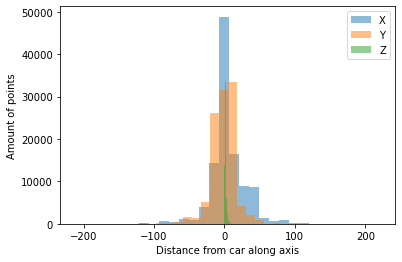

In [95]:
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.hist(lidar_pointcloud.points[2], alpha=0.5, bins=30, label="Z")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [78]:
# lidar_pointcloud, times = LidarPointCloud.from_file_multisweep(level5data, sample, "LIDAR_TOP",
#                                                                            "LIDAR_TOP",
#                                                                            num_sweeps=10)


In [83]:
# points = lidar_pointcloud.points  # .transpose()  # .reshape(-1, 5)

# # points = points[:3, :]
# # points[:3, :] = points
# points[3, :] /= 255
# points[3, :] -= 0.5
# points[3, :]

array([-0.10784314, -0.10784314, -0.10784314, ..., -0.10784314,
       -0.10784314, -0.10784314])

In [84]:
# np.concatenate([points, times], axis=0).transpose()

array([[12.74068737, -5.82185364,  3.74578691, -0.10784314,  0.        ],
       [12.70274448, -5.85819721,  3.7406199 , -0.10784314,  0.        ],
       [11.75732517, -5.47204685,  3.46782374, -0.10784314,  0.        ],
       ...,
       [ 2.34112   ,  3.02272654, -1.7672658 , -0.10784314,  0.        ],
       [ 2.3538909 ,  3.01739836, -1.76894391, -0.10784314,  0.        ],
       [16.11400414, 12.97545719, -9.56303883, -0.10784314,  0.        ]])

## Filtering boxes

In [109]:
level5data.sample

[{'next': '1d2350b3b20e3a5db2407e4075fc14f9f9ddfe0018f1daa79cf251f480b648c2',
  'prev': '14511199ea101b40683cefafb9fcf5c2fb512fa500c3e6b241f31cfa327c5ea4',
  'token': 'b98a05255ba2632e957884758cb31f0e6fcc8d3cd6ee76b6d0ba55b72f08fc54',
  'timestamp': 1552083686901126.0,
  'scene_token': '18c6c670114eebd813ef240b05b988646bbccbbc5254df49984c2173fe274d19',
  'data': {'CAM_FRONT_LEFT': 'e589c605992faf36991054408e1bb129dfc7bc7e7a8e947c36c2c125c6ffc763',
   'CAM_BACK_LEFT': '95098aeae9cf01b7e13002b2e42f5660a66e04fc576c403394348e8c482a835b',
   'CAM_FRONT_RIGHT': '6af853c5f25515e2ad58fa54700bfeee43e37b40e50f5dcf1aec01a9132d714a',
   'LIDAR_TOP': 'ee08f2c37365e52a8982004ebb915899f2134d7a17f254fcb4137c9df30976f7',
   'CAM_FRONT_ZOOMED': '948d09b37cff10c80241f18f5bc4607909e76fb21cd7d1c480b64d5429448d44',
   'CAM_FRONT': '02e02fb754b503c83ec0d9455168733c62397b42a50ec36206a5cb8f84d88e1f',
   'CAM_BACK': '1aaf30d16d26bb2dc4486aafe6686bb446c3788b751d4ba2ff77a73c59b17488',
   'CAM_BACK_RIGHT': '7c3de6

In [110]:
len(level5data.sample)

22680

In [136]:
target_class = 'truck'
filtered_sample = []
classes = ['car', 'animal', 'emergency_vehicle', 'truck', 'pedestrian', 'bus', 'motorcycle', 'other_vehicle', 'bicycle']
for sample in tqdm_notebook(level5data.sample):
    sample_token = sample['token']
    sample_lidar_token = sample['data']['LIDAR_TOP']
    boxes = level5data.get_boxes(sample_lidar_token)
    for box in boxes:
        if box.name in target_class:
            filtered_sample.append(sample) 
            break

<ipython-input-136-721254e83dc4>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(level5data.sample):


  0%|          | 0/22680 [00:00<?, ?it/s]

In [127]:
len(filtered_sample)

9232

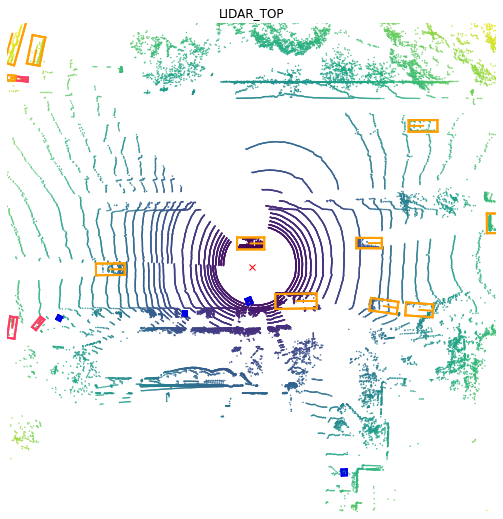

In [130]:
level5data.render_sample_data(filtered_sample[0]['data']['LIDAR_TOP'])

In [140]:
boxes[0]

label: nan, score: nan, xyz: [1034.79, 1840.72, -23.86], wlh: [0.82, 0.94, 1.75], rot axis: [0.00, 0.00, 1.00], ang(degrees): -106.27, ang(rad): -1.85, vel: nan, nan, nan, name: pedestrian, token: 026a246e8bfda03483669aca402afe3c90174c1ba931ec3ed679a7d072b295d9